<a href="https://colab.research.google.com/github/maragraziani/InterpretabilityVISUM22/blob/main/Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VISUM 2022 - Exaplainable AI - Hands on session**
# Explainability for Vision Models
**led by Mara Graziani**
* postdoctoral researcher at Hes-so Valais and IBM Research x ZHAW
* mara.graziani@hevs.ch ; @mormontre

**Content**

1.  Gradient based methods: Gradient-weighted Class Activation Maps (Grad-CAM)
and Integrated Gradients
2.  Model agnostic: LIME and Sharp-LIME
3.  Concept-based post-hoc attribution

**References**
* Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017.
* Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
* Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. "" Why should i trust you?" Explaining the predictions of any classifier." Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 2016.
* Graziani, Mara, et al. "Sharpening Local Interpretable Model-Agnostic Explanations for Histopathology: Improved Understandability and Reliability." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2021.
* Kim, Been, et al. "Interpretability beyond feature attribution: Quantitative testing with concept activation vectors (tcav)." International conference on machine learning. PMLR, 2018.
* Graziani, Mara, Vincent Andrearczyk, and Henning Müller. "Regression concept vectors for bidirectional explanations in histopathology." Understanding and Interpreting Machine Learning in Medical Image Computing Applications. Springer, Cham, 2018. 124-132.

### Exploring further
If you want to further dive into the research in Interpretable AI, do not hesitate to look into the following toolboxes:
- Introduction to AI Interpretability - [Online course](https://introinterpretableai.wordpress.com)
- Captum
- Explainable AI 360
- Quantus. I would like to thank Anna Hedström (<hedstroem.anna@gmail.com>) for her insights on XAI evaluation toolbox that she developed. For any questions concerning Quantus feel free to directly reach out to her. 


### Installation and Set up


In [10]:
!git clone https://github.com/maragraziani/InterpretabilityVISUM22.git

Cloning into 'InterpretabilityVISUM22'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 219 (delta 5), reused 1 (delta 1), pack-reused 212
Receiving objects: 100% (219/219), 7.62 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [ ]:
!pip install captum opencv-python 
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [ ]:
import sys
import warnings
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
import os
import cv2
import PIL
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True
torch.cuda.empty_cache()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

clear_output()

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-05-17 11:56:42--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.226.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.226.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.06s   

2022-05-17 11:56:42 (553 KB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [ ]:
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()

# Creating wrapper to access gradient values
class DenseNet(torch.nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = torchvision.models.densenet201(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1920))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

' deprecated for now\nclass ResNet18(torch.nn.Module):\n    def __init__(self, model):\n        super(ResNet18, self).__init__()\n        \n        # get the pretrained  network\n        self.model = model#torchvision.models.resnet18(pretrained=True)\n        \n        # disect the network to access its last convolutional layer\n        self.features_conv = self.model.layer4\n        \n        # get the max pool of the features stem\n        #self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n        self.global_avg_pool = torch.nn.AvgPool2d(kernel_size=7, stride=1)\n        \n        # get the classifier of the vgg19\n        self.classifier = self.model.fc\n        \n        # placeholder for the gradients\n        self.gradients = None\n    \n    # hook for the gradients of the activations\n    def activations_hook(self, grad):\n        self.gradients = grad\n        \n    def forward(self, x):\n        x = self.features_conv(x)\n   

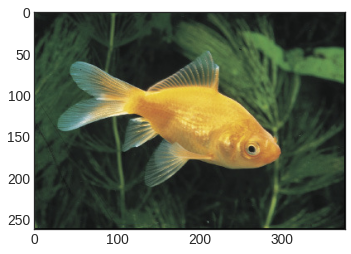

In [ ]:
# load imagenet sample and apply standard transforms
imagenet_samples_dir = "/content/InterpretabilityVISUM22/data/imagenet/"
img = PIL.Image.open(imagenet_samples_dir+'n01443537/n01443537_goldfish.JPEG')
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
#plt.imshow(np.swapaxes(np.asarray(input[0]), 0,2))

In [ ]:
images=[]
for image_dir in os.listdir(imagenet_samples_dir):
  if ".md" not in image_dir:
    for image_path in os.listdir(os.path.join(imagenet_samples_dir,image_dir)):
        dir_=os.path.join(imagenet_samples_dir,image_dir)
        image = PIL.Image.open(os.path.join(dir_, image_path))
        #transformed_img = transform(img)
        #input = transform_normalize(transformed_img)
        #input = input.unsqueeze(0)
        images.append(image) 
#transformed_inputs=torch.stack(tuple(transform_normalize(i) for i in images), dim=0)

## 1. Gradient-based methods

### 1A. Grad-CAM

#### Theory

#### Practice


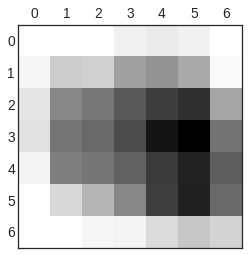

In [ ]:
# generating prediction from wrapped model
densenet = DenseNet()
pred = densenet(input)
class_idx = pred.argmax(dim=1).item()
pred[:, class_idx].backward()

# getting the gradients
gradients = densenet.get_activations_gradient()

# pooling the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# geting the activations of the last convolutional layer
activations = densenet.get_activations(input).detach()

# weighting the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# averaging the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalizing the heatmap
heatmap /= torch.max(heatmap)

# visualization
plt.matshow(heatmap.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


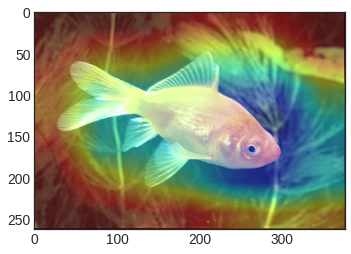

In [ ]:
# Mapping back to the original input image
img=np.asarray(img, dtype=np.float32)
heatmap = cv2.resize(np.asarray(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
plt.imshow(np.asarray(superimposed_img, dtype=np.int))

#### Exercises

> Indented block





### 1B. Integrated Gradients with Captum

#### Theory
From the paper "Axiomatic Attribution for Deep Networks":

Consider the straightline path from the baseline x′ to the input x, and compute the gradients at all points along the path. Integrated gradients are obtained by cumulating these gradients.
Integrated gradients aggregate the gradients along the inputs that fall on the straightline between the baseline and the input.

Specifically, integrated gradients are defined as the path intergral of the gradients along the straightline path from the baseline x′ to the input x.


#### Practice

In [ ]:
import captum
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients

del model
# Loading the model 
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=50)


Predicted: goldfish ( 0.9041939973831177 )


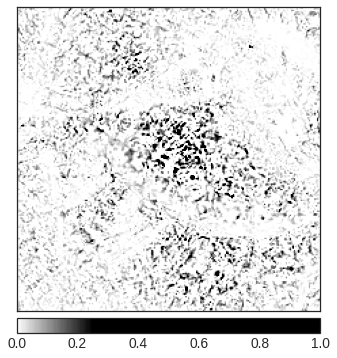

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


#### Exercises


## 2. Local Interpretable Model-agnostic Explanations (LIME)


In [ ]:
!pip install lime

Predicted: red_wine ( 0.7952153086662292 )


  0%|          | 0/200 [00:00<?, ?it/s]

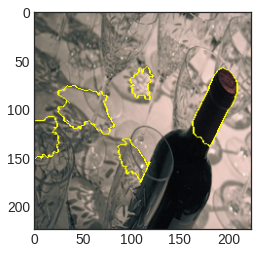

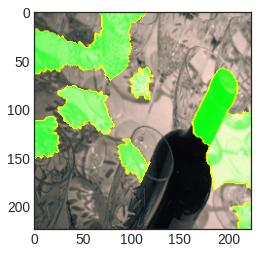

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf
pill_transf = get_pil_transform()

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]) 
    return transf
preprocess_transform = get_preprocess_transform()

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    #batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

image_idx=1
input_img = transform_normalize(transform(images[image_idx])).unsqueeze(0)
output = model(input_img)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(np.asarray(pill_transf(images[image_idx])),
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=200) # number of images that will be sent to classification function


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry1)
print()
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.figure()
plt.imshow(img_boundry2)

### Sharpening Local Interpretable Model-Agnostic Explanations (Sharp-LIME)

In [ ]:
!git clone https://github.com/maftouni/binary_mask_from_json.git

fatal: destination path 'binary_mask_from_json' already exists and is not an empty directory.


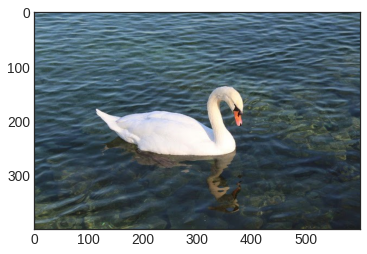

In [ ]:
img = PIL.Image.open("/content/binary_mask_from_json/sample_frames/adutta_swan.jpg")
plt.imshow(img)
transformed_img = transform(img)
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

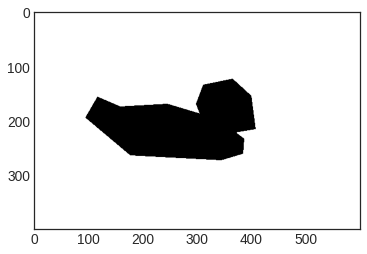

In [ ]:
mask = np.asarray(PIL.Image.open("/content/binary_mask_from_json/binary_masks/00000.png"))
plt.imshow(mask)

In [ ]:
mask2 = mask.copy()
mask2[:,:300] = 0

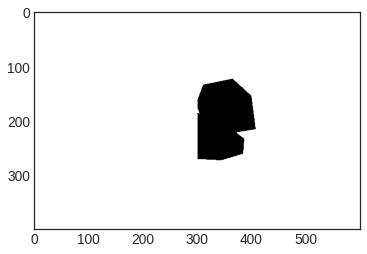

In [ ]:
plt.imshow(mask2)

In [ ]:
del model
model = torchvision.models.densenet201(pretrained=True)
model = model.eval()
output = model(input)
output = torch.nn.functional.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]

print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.6745553016662598 )


In [ ]:
from lime import lime_image
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask, dtype=np.int)
predict=model(input)
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(transform_normalize(transform(PIL.Image.fromarray(i))) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    probs = model(batch)
    #probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()
#quickshift_segs = segments_quickshift(im)
#Generate LIME explanation for class 1
explainer = lime_image.LimeImageExplainer()
class_idx = pred_label_idx.item()
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = None,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

In [ ]:
dict_genetic = dict(explanation_genetic.local_exp[class_idx])
heatmap = np.vectorize(dict_genetic.get)(explanation_genetic.segments)
orig_rank=sorted(dict_genetic, key=dict_genetic.get, reverse=True)

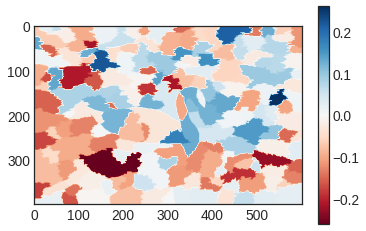

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

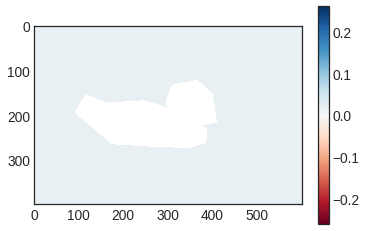

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
def segfunc(img):
        return np.asarray(np.ones(mask.shape)-mask2, dtype=np.int)

explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

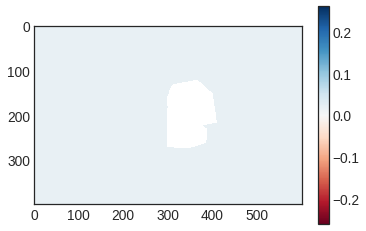

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
#def get_segments(mask):
squares = np.zeros(mask.shape[:2])
fract = int(mask.shape[0]/6)
fract1=int(mask.shape[1]/6)
counter = 0
for hor in range(6):
    for ver in range(6):
        squares[fract*hor:fract*(hor+1),fract1*ver:fract1*(ver+1)]=counter
        counter+=1

segments = (np.ones(mask.shape)-mask/5.) + squares
#print(np.unique(segments))

temp_renumber = [2+item for item in list(range(len(np.unique(segments))))]

renumbering_map = dict(zip(np.unique(segments),temp_renumber))

segments = np.vectorize(renumbering_map.get)(segments)
segments = np.where(segments.copy()==8,squares,segments)

def segfunc(img):
        return segments
explanation_genetic = explainer.explain_instance(np.asarray(img), 
                                                batch_predict, 
                                                  segmentation_fn = segfunc,
                                                     top_labels=3,#Just making sure we generate explanations for both classes. Any number >2 should work. 
                                                     hide_color=0,#Cover superpixels in black. 
                                                     num_samples=20,
                                                     progress_bar=False)

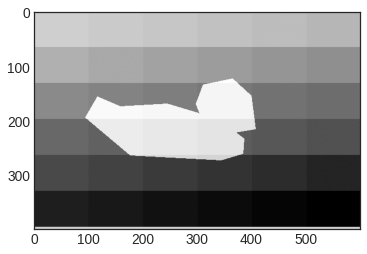

In [ ]:
plt.imshow(segments)

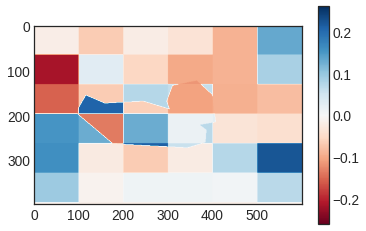

In [ ]:
plt.imshow(np.vectorize(dict_genetic.get)(explanation_genetic.segments), cmap = 'RdBu', vmin=-heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## 3. Concept-based Post-Hoc Attribution

### 3A. TCAV (Testing with Concept Activation Vectors) with Captum

#### Theory



In [ ]:
from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

def assemble_concept(name, id, concepts_path="data/tcav/image/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [ ]:
import PIL.Image as Image
def get_tensor_from_filename(filename):
    img = PIL.Image.open(filename).convert("RGB")
    return transform(img)

concepts_path = "/content/InterpretabilityVISUM22/data/tcav/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzag", 1, concepts_path=concepts_path)
#dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)

random_0_concept = assemble_concept("random500_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random500_1", 4, concepts_path=concepts_path)

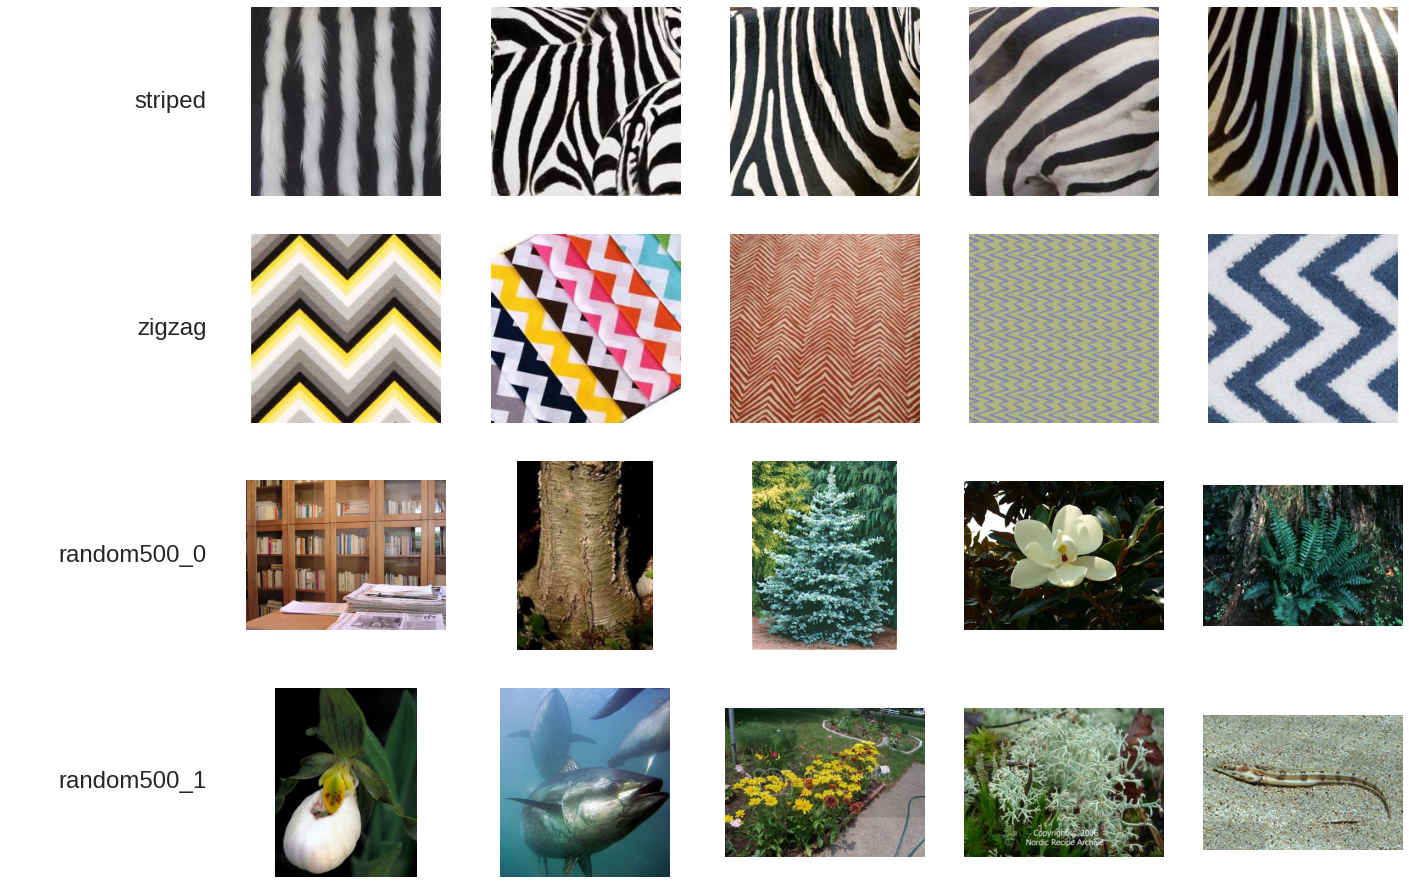

In [ ]:
import glob
n_figs = 5
n_concepts = 4

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


In [ ]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]

In [ ]:
# Load sample images from folder
def load_image_tensors(class_name, root_path='data/tcav/image/imagenet/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = PIL.Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors
zebra_imgs = load_image_tensors('zebra', transform=False, root_path='/content/InterpretabilityVISUM22/data/tcav/')

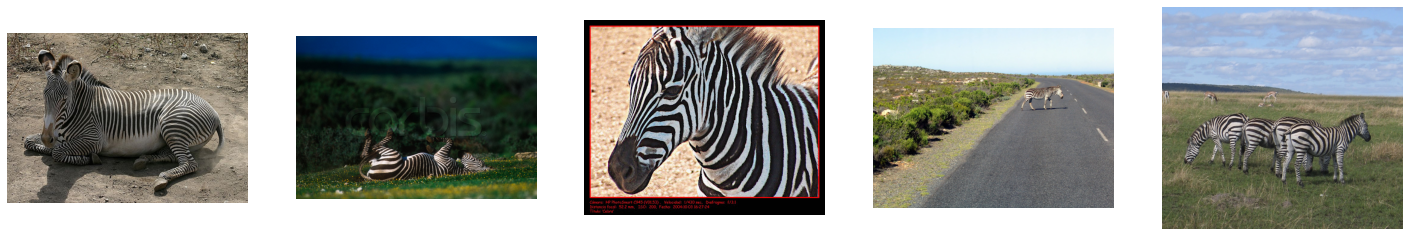

In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[0])
axs[1].imshow(zebra_imgs[1])
axs[2].imshow(zebra_imgs[2])
axs[3].imshow(zebra_imgs[3])
axs[4].imshow(zebra_imgs[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [ ]:
# Load sample images from folder
zebra_tensors = torch.stack([transform_normalize(transform(img)) for img in zebra_imgs])
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random500_0')],
 [Concept(0, 'striped'), Concept(4, 'random500_1')]]

In [ ]:
# zebra class index

zebra_ind = 340

tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>>,
            {'0-3': defaultdict(None,
                         {'inception4c': {'magnitude': tensor([ 1.7905, -1.7905]),
                           'sign_count': tensor([0.5714, 0.4286])},
                          'inception4d': {'magnitude': tensor([ 8.4330, -8.4330]),
                           'sign_count': tensor([1., 0.])},
                          'inception4e': {'magnitude': tensor([ 4.4899, -4.4899]),
                           'sign_count': tensor([1., 0.])}}),
             '0-4': defaultdict(None,
                         {'inception4c': {'magnitude': tensor([ 0.0210, -0.0210]),
                           'sign_count': tensor([0.7143, 0.2857])},
                          'inception4d': {'magnitude': tensor([ 3.5676, -3.5676]),
                           'sign_count': tensor([0.8571, 0.1429])},
                          'inception4e': {'magnitude': tensor([ 3.6036, -3.6036]),
                 

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

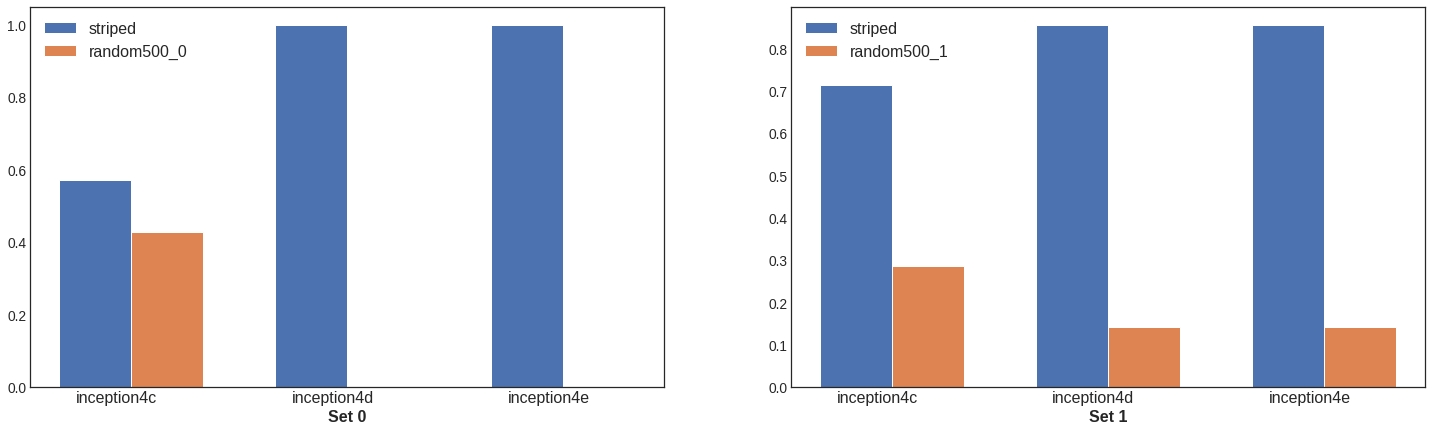

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

### 3B. Analysis of Continuous Valued Concepts: Regression Concept Vectors

In [ ]:
!pip install rcvtool

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras 
import matplotlib.pyplot as plt
import rcvtool
import numpy as np


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


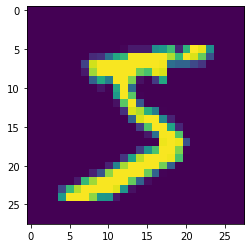

In [4]:
plt.imshow(x_train[0])


In [5]:
rcvtool.get_all_texture_measures(x_train[0])

/usr/local/lib/python3.7/dist-packages/rcvtool/rcv.py:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  skimage.img_as_ubyte(skimage.color.rgb2gray(image)),


{'ASM': array([[0.56878219]]),
 'contrast': array([[1789.86243386]]),
 'correlation': array([[0.86298341]]),
 'dissimilarity': array([[14.71164021]]),
 'energy': array([[0.7541765]]),
 'homogeneity': array([[0.80615506]])}

In [16]:
rcvtool.get_texture_measure(x_train[0], mtype='ASM')

/usr/local/lib/python3.7/dist-packages/rcvtool/rcv.py:40: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  skimage.img_as_ubyte(skimage.color.rgb2gray(image)),


array([[0.56878219]])

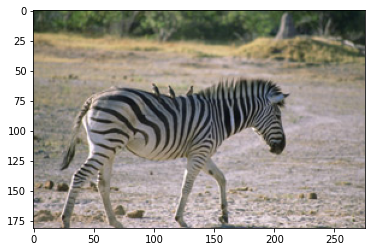

In [14]:
img = PIL.Image.open("InterpretabilityVISUM22/data/tcav/Zebra.jpg").convert('RGB')
plt.imshow(img)
sample_img=img

In [17]:
resized_sample = sample_img.resize((229,299), PIL.Image.NEAREST)
print(np.asarray(resized_sample).shape)
input_sample = np.zeros((2, 299,299,3))

(299, 229, 3)


Text(0.5, 1.0, 'Texture')

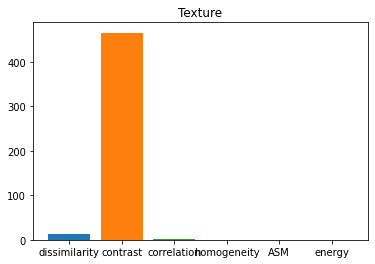

In [18]:
import cv2
img=np.asarray(resized_sample)
textures=rcvtool.get_all_texture_measures(img)
for k in textures.keys():
    plt.bar(k, textures[k][0])
plt.title("Texture")


Text(0.5, 1.0, 'Color')

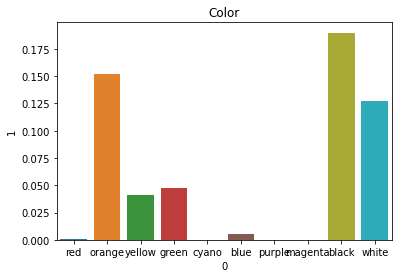

In [19]:
img_bgr=img[:, :, ::-1]
colors=rcvtool.get_all_color_measures(img_bgr, verbose=False)
import seaborn as sns
import pandas as pd
data=pd.DataFrame(data={0: [k for k in colors.keys()], 1:[colors[k] for k in colors.keys()]})
fig=plt.figure()
sns.barplot(x=0, y=1,data=data.where(data!='colorfulness'))
plt.title("Color")
